In [1]:
#The packages... the packages... all of... the packages!
import math
import pandas as pd
import numpy as np
from operator import itemgetter

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

from sklearn import tree
from sklearn.tree import _tree

from sklearn.ensemble import RandomForestRegressor 
from sklearn.ensemble import RandomForestClassifier 

from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

import warnings
warnings.filterwarnings("ignore")

sns.set()
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [2]:
#Let's read in some data with which we can work

INFILE = r"C:\Users\jaysa\OneDrive\Desktop\Practical Machine Learning\Assignment 3 Files\HMEQ_Loss.csv"

TARGET_B = "TARGET_BAD_FLAG" #Target_F in car insurance example
TARGET_L = "TARGET_LOSS_AMT" #Target_A in car insurance example


df = pd.read_csv( INFILE )

dt = df.dtypes
dt

TARGET_BAD_FLAG      int64
TARGET_LOSS_AMT    float64
LOAN                 int64
MORTDUE            float64
VALUE              float64
REASON              object
JOB                 object
YOJ                float64
DEROG              float64
DELINQ             float64
CLAGE              float64
NINQ               float64
CLNO               float64
DEBTINC            float64
dtype: object

In [3]:
#There's no data like clean data

objList = []
numList = []
for i in dt.index :
    if i in ( [ TARGET_B, TARGET_L ] ) : continue
    if dt[i] in (["object"]) : objList.append( i )
    if dt[i] in (["float64","int64"]) : numList.append( i )
        
dt = df.dtypes
objList = []
for i in dt.index :
    if i in ( [ TARGET_B, TARGET_L ] ) : continue
    if dt[i] in (["object"]) : objList.append( i )

#Clean data doesn't like missing values

for i in objList :
    print( i )
    print( df[i].unique() )
    g = df.groupby( i )
    print( g[i].count() )
    print( "MOST COMMON = ", df[i].mode()[0] )   
    print( "MISSING = ", df[i].isna().sum() )
    print( "\n\n")
    
for i in objList :
    if df[i].isna().sum() == 0 : continue
    print( i ) 
    print("HAS MISSING")
    NAME = "IMP_"+i
    print( NAME ) 
    df[NAME] = df[i]
    df[NAME] = df[NAME].fillna(df[NAME].mode()[0] )
    print( "variable",i," has this many missing", df[i].isna().sum() )
    print( "variable",NAME," has this many missing", df[NAME].isna().sum() )
    g = df.groupby( NAME )
    print( g[NAME].count() )
    print( "\n\n")
    df = df.drop( i, axis=1 )
        
#Now our imputed reason and imputed job variables have no missing values. Let's rank the job tiers as a kind of corporate 
#ladder and create associated flag variables for each. In this ladder, the ProfExe is on top, followed by the Mgr, then
#Office, next Sales, Self, and finally Other.

print( df["IMP_JOB"].unique() )

df["y_IMP_JOB_6"] = (df.IMP_JOB.isin( ["ProfExe"] ) + 0 )
df["y_IMP_JOB_5"] = (df.IMP_JOB.isin( ["ProfExe","Mgr"] ) + 0)
df["y_IMP_JOB_4"] = (df.IMP_JOB.isin( ["ProfExe","Mgr","Office"] ) + 0)
df["y_IMP_JOB_3"] = (df.IMP_JOB.isin( ["ProfExe","Mgr","Office","Sales"] ) + 0)
df["y_IMP_JOB_2"] = (df.IMP_JOB.isin( ["ProfExe","Mgr","Office","Sales","Self"] ) + 0)
df["y_IMP_JOB_1"] = (df.IMP_JOB.isin( ["ProfExe","Mgr","Office","Sales","Self","Other"] ) + 0)
df = df.drop( "IMP_JOB", axis=1 )


#We also need to rank the reasons for the HMEQ. Since we found home improvement has a lower default rate the debt
#consolidation previously, we will assign home improvement the higher rank. We need to do this for both ObjList variables
#to build our decision tree model

print( df["IMP_REASON"].unique() )

df["y_IMP_REASON_2"] = (df.IMP_REASON.isin( ["HomeImp"] ) + 0 )
df["y_IMP_REASON_1"] = (df.IMP_REASON.isin( ["HomeImp","DebtCon"] ) + 0)
df = df.drop( "IMP_REASON", axis=1 )

#Let's verify that we have no more object type variables
dt = df.dtypes
objList = []
for i in dt.index :
    print(" here is i .....", i , " ..... and here is the type", dt[i] )
    if i in ( [ TARGET_B, TARGET_L ] ) : continue
    if dt[i] in (["object"]) : objList.append( i )


for i in objList :
    thePrefix = "z_" + i
    y = pd.get_dummies( df[i], prefix=thePrefix, drop_first=True )   
    y = pd.get_dummies( df[i], prefix=thePrefix )   
    df = pd.concat( [df, y], axis=1 )
    df = df.drop( i, axis=1 )

REASON
['HomeImp' nan 'DebtCon']
REASON
DebtCon    3928
HomeImp    1780
Name: REASON, dtype: int64
MOST COMMON =  DebtCon
MISSING =  252



JOB
['Other' nan 'Office' 'Sales' 'Mgr' 'ProfExe' 'Self']
JOB
Mgr         767
Office      948
Other      2388
ProfExe    1276
Sales       109
Self        193
Name: JOB, dtype: int64
MOST COMMON =  Other
MISSING =  279



REASON
HAS MISSING
IMP_REASON
variable REASON  has this many missing 252
variable IMP_REASON  has this many missing 0
IMP_REASON
DebtCon    4180
HomeImp    1780
Name: IMP_REASON, dtype: int64



JOB
HAS MISSING
IMP_JOB
variable JOB  has this many missing 279
variable IMP_JOB  has this many missing 0
IMP_JOB
Mgr         767
Office      948
Other      2667
ProfExe    1276
Sales       109
Self        193
Name: IMP_JOB, dtype: int64



['Other' 'Office' 'Sales' 'Mgr' 'ProfExe' 'Self']
['HomeImp' 'DebtCon']
 here is i ..... TARGET_BAD_FLAG  ..... and here is the type int64
 here is i ..... TARGET_LOSS_AMT  ..... and here is the type flo

In [4]:
#Groovy! No more object variables. We need to remove missing values for numList variables, too. Here, we will apply 
#the median value of the appropriate category for simplicity

for i in numList :
    if df[i].isna().sum() == 0 : continue
    IMP = "IMP_" + i
    df[ IMP ] = df[ i ]
    df.loc[ df[IMP].isna(), IMP ] = df[i].median()
    df = df.drop( i, axis=1 )

In [5]:
#And last, but not least, let's handle the outliers.

dt = df.dtypes
numList = []
for i in dt.index :
    print(i, dt[i])
    if i in ( [ TARGET_B, TARGET_L ] ) : continue
    if dt[i] in (["float64","int64"]) : numList.append( i )


for i in numList :
    theMean = df[i].mean()
    theSD = df[i].std()
    theMax = df[i].max()
    theCutoff = round( theMean + 3*theSD )
    if theMax < theCutoff : continue
    FLAG = "O_" + i
    TRUNC = "TRUNC_" + i
    df[ FLAG ] = ( df[i] > theCutoff )+ 0
    df[ TRUNC ] = df[ i ]
    df.loc[ df[TRUNC] > theCutoff, TRUNC ] = theCutoff
    df = df.drop( i, axis=1 )

for i in objList:
    df = df.drop( i, axis=1 )

TARGET_BAD_FLAG int64
TARGET_LOSS_AMT float64
LOAN int64
y_IMP_JOB_6 int32
y_IMP_JOB_5 int32
y_IMP_JOB_4 int32
y_IMP_JOB_3 int32
y_IMP_JOB_2 int32
y_IMP_JOB_1 int32
y_IMP_REASON_2 int32
y_IMP_REASON_1 int32
IMP_MORTDUE float64
IMP_VALUE float64
IMP_YOJ float64
IMP_DEROG float64
IMP_DELINQ float64
IMP_CLAGE float64
IMP_NINQ float64
IMP_CLNO float64
IMP_DEBTINC float64


In [6]:
#Split the data

X = df.copy() #We are removing the target variables from X
X = X.drop( TARGET_B, axis=1 )
X = X.drop( TARGET_L, axis=1 )

Y = df[ [TARGET_B, TARGET_L] ] #And adding the target variables to Y

#This creates a training and testing data set where the train_size/test_size variables are the percentage of
#records assigned to each group. Here 80% go to the training group and 20% go to the testing group
#Assigning a random_state for the random number seed will produce repeatable split of test and training
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=2)

print( "FLAG DATA" )
print( "TRAINING = ", X_train.shape )  # number of records assigned, number of variables
print( "TEST = ", X_test.shape )

#Let's now separate out records of people who actually defaulted on a loan to predict the amount of loss 
#of the defaulted loans. We want to apply this to both training and test data

F = ~ Y_train[ TARGET_L ].isna()
W_train = X_train[F].copy()
Z_train = Y_train[F].copy()

F = ~ Y_test[ TARGET_L ].isna()
W_test = X_test[F].copy()
Z_test = Y_test[F].copy()

print( Z_train.describe() )
print( Z_test.describe() )

#We can see that the average loss on a defaulted loan is a little over $13,000 in both datasets. However, there are large
#outliers that may skew the decision tree. Let's deal with those outliers. The median loss is about $11,000 as is the
#standard deviation, so let's cap outlier amounts at $33,000

F = Z_train[ TARGET_L ] > 33000
Z_train.loc[ F, TARGET_L ] = 33000

F = Z_test[ TARGET_L ] > 33000
Z_test.loc[ F, [TARGET_L] ] = 33000

print( Z_train.describe() )
print( Z_test.describe() )

print( " ====== ")

print( "AMOUNT DATA" )
print( "TRAINING = ", W_train.shape )
print( "TEST = ", Z_test.shape )

FLAG DATA
TRAINING =  (4768, 28)
TEST =  (1192, 28)
       TARGET_BAD_FLAG  TARGET_LOSS_AMT
count            941.0       941.000000
mean               1.0     13634.824655
std                0.0     10836.172568
min                1.0       224.000000
25%                1.0      5837.000000
50%                1.0     11266.000000
75%                1.0     18069.000000
max                1.0     78987.000000
       TARGET_BAD_FLAG  TARGET_LOSS_AMT
count            248.0       248.000000
mean               1.0     12578.879032
std                0.0     10833.019569
min                1.0       320.000000
25%                1.0      4921.000000
50%                1.0      9693.500000
75%                1.0     15601.250000
max                1.0     73946.000000
       TARGET_BAD_FLAG  TARGET_LOSS_AMT
count            941.0       941.000000
mean               1.0     12976.925611
std                0.0      8814.955812
min                1.0       224.000000
25%                1.0      

In [7]:
#Phew! Now that's some squeaky clean data. Let's now define some functions since we're building several models

def getProbAccuracyScores( NAME, MODEL, X, Y ) :
    pred = MODEL.predict( X )
    probs = MODEL.predict_proba( X )
    acc_score = metrics.accuracy_score(Y, pred)
    p1 = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve( Y, p1)
    auc = metrics.auc(fpr,tpr)
    return [NAME, acc_score, fpr, tpr, auc]

def print_ROC_Curve( TITLE, LIST ) :
    fig = plt.figure(figsize=(6,4))
    plt.title( TITLE )
    for theResults in LIST :
        NAME = theResults[0]
        fpr = theResults[2]
        tpr = theResults[3]
        auc = theResults[4]
        theLabel = "AUC " + NAME + ' %0.2f' % auc
        plt.plot(fpr, tpr, label = theLabel )
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

def print_Accuracy( TITLE, LIST ) :
    print( TITLE )
    print( "======" )
    for theResults in LIST :
        NAME = theResults[0]
        ACC = theResults[1]
        print( NAME, " = ", ACC )
    print( "------\n\n" )

def getAmtAccuracyScores( NAME, MODEL, X, Y ) :
    pred = MODEL.predict( X )
    MEAN = Y.mean()
    RMSE = math.sqrt( metrics.mean_squared_error( Y, pred))
    return [NAME, RMSE, MEAN]

def getCoefLogit( MODEL, TRAIN_DATA ) :
    varNames = list( TRAIN_DATA.columns.values )
    coef_dict = {}
    coef_dict["INTERCEPT"] = MODEL.intercept_[0]
    for coef, feat in zip(MODEL.coef_[0],varNames):
        coef_dict[feat] = coef
    print("\nDefault")
    print("---------")
    print("Total Variables: ", len( coef_dict ) )
    for i in coef_dict :
        print( i, " = ", coef_dict[i]  )



def getCoefLinear( MODEL, TRAIN_DATA ) :
    varNames = list( TRAIN_DATA.columns.values )
    coef_dict = {}
    coef_dict["INTERCEPT"] = MODEL.intercept_
    for coef, feat in zip(MODEL.coef_,varNames):
        coef_dict[feat] = coef
    print("\nLoss")
    print("---------")
    print("Total Variables: ", len( coef_dict ) )
    for i in coef_dict :
        print( i, " = ", coef_dict[i]  )

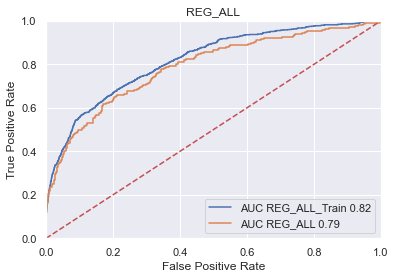

REG_ALL CLASSIFICATION ACCURACY
REG_ALL_Train  =  0.8456375838926175
REG_ALL  =  0.8313758389261745
------


REG_ALL RMSE ACCURACY
REG_ALL_Train  =  3584.9952087330803
REG_ALL  =  4147.165955888475
------




In [8]:
#Let's start creating some models! First, using all variables

#Logistic Regression for probability of car crash

WHO = "REG_ALL"

CLM = LogisticRegression( solver='newton-cg', max_iter=500 )
CLM = CLM.fit( X_train, Y_train[ TARGET_B ] )

TRAIN_CLM = getProbAccuracyScores( WHO + "_Train", CLM, X_train, Y_train[ TARGET_B ] )
TEST_CLM = getProbAccuracyScores( WHO, CLM, X_test, Y_test[ TARGET_B ] )

print_ROC_Curve( WHO, [ TRAIN_CLM, TEST_CLM ] ) 
print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )

#Linear Regression for determining expected loss if loan defaults

AMT = LinearRegression()
AMT = AMT.fit( W_train, Z_train[TARGET_L] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, W_train, Z_train[TARGET_L] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, W_test, Z_test[TARGET_L] )
print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )


varNames = list( X_train.columns.values )

REG_ALL_CLM = TEST_CLM.copy()
REG_ALL_AMT = TEST_AMT.copy()

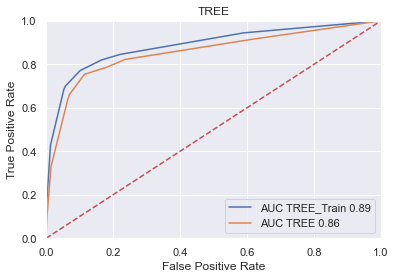

TREE CLASSIFICATION ACCURACY
TREE_Train  =  0.8951342281879194
TREE  =  0.8733221476510067
------


TREE RMSE ACCURACY
TREE_Train  =  3205.179399572641
TREE  =  4798.8775440606805
------




In [33]:
#Hey, that's not bad! Almost 80% accuracy using all variables. Even better, the root mean squared error is fairly 
#consistent from training to test data and is relatively low. What does the decision tree have to say about which 
#variables are best?

def getTreeVars( TREE, varNames ) :
    tree_ = TREE.tree_
    varName = [ varNames[i] if i != _tree.TREE_UNDEFINED else "undefined!" for i in tree_.feature ]

    nameSet = set()
    for i in tree_.feature :
        if i != _tree.TREE_UNDEFINED :
            nameSet.add( i )
    nameList = list( nameSet )
    parameter_list = list()
    for i in nameList :
        parameter_list.append( varNames[i] )
    return parameter_list

WHO = "TREE"

CLM = tree.DecisionTreeClassifier( max_depth=5 )
CLM = CLM.fit( X_train, Y_train[ TARGET_B ] )

TRAIN_CLM = getProbAccuracyScores( WHO + "_Train", CLM, X_train, Y_train[ TARGET_B ] )
TEST_CLM = getProbAccuracyScores( WHO, CLM, X_test, Y_test[ TARGET_B ] )

print_ROC_Curve( WHO, [ TRAIN_CLM, TEST_CLM ] ) 
print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )

feature_cols = list( X.columns.values )
tree.export_graphviz(CLM,out_file='tree_f.txt',filled=True, rounded=True, feature_names = feature_cols, impurity=False, class_names=["Good","Bad"]  )
vars_tree_flag = getTreeVars( CLM, feature_cols ) 


# Predict the losses!

AMT = tree.DecisionTreeRegressor( max_depth= 5 )
AMT = AMT.fit( W_train, Z_train[TARGET_L] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, W_train, Z_train[TARGET_L] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, W_test, Z_test[TARGET_L] )
print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )

feature_cols = list( X.columns.values )
vars_tree_amt = getTreeVars( AMT, feature_cols ) 


TREE_CLM = TEST_CLM.copy()
TREE_AMT = TEST_AMT.copy()

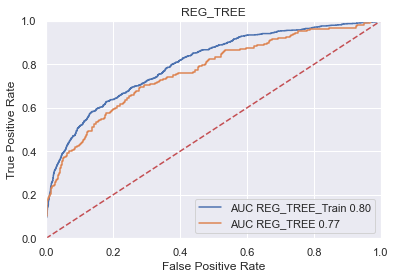

REG_TREE CLASSIFICATION ACCURACY
REG_TREE_Train  =  0.8424916107382551
REG_TREE  =  0.822986577181208
------


REG_TREE RMSE ACCURACY
REG_TREE_Train  =  3759.3195660777837
REG_TREE  =  4310.25669707498
------



Default
---------
Total Variables:  11
INTERCEPT  =  -2.9343757966398547
O_LOAN  =  0.2516693688069112
TRUNC_LOAN  =  -2.2625165549957404e-05
TRUNC_IMP_VALUE  =  -5.340099146026939e-07
TRUNC_IMP_DEROG  =  0.7405373851053305
O_IMP_DELINQ  =  1.753206615645987
TRUNC_IMP_DELINQ  =  0.7179635843931598
TRUNC_IMP_CLAGE  =  -0.006375372294219223
TRUNC_IMP_NINQ  =  0.1802495228237784
TRUNC_IMP_CLNO  =  -0.011390306483613706
TRUNC_IMP_DEBTINC  =  0.07108031242777138

Loss
---------
Total Variables:  9
INTERCEPT  =  -2914.931789562046
y_IMP_JOB_4  =  -322.84282329290045
y_IMP_REASON_2  =  -1757.1265464953015
TRUNC_LOAN  =  0.6085641257286625
TRUNC_IMP_YOJ  =  -57.021075277675706
TRUNC_IMP_DELINQ  =  1138.2143536067922
TRUNC_IMP_CLAGE  =  -23.510445474310597
TRUNC_IMP_CLNO  =  235.0585424

In [10]:
#The good news is that the decision tree does a great job of determining the probability of a default. The bad news is that
#RMSE is largely divergent between the training and testing data. The error was greater than taking all variables together.
#Maybe the regression for the decision tree will perform better? Let's use the variables the decision tree liked.

WHO = "REG_TREE"

CLM = LogisticRegression( solver='newton-cg', max_iter=500 )
CLM = CLM.fit( X_train[vars_tree_flag], Y_train[ TARGET_B ] )

TRAIN_CLM = getProbAccuracyScores( WHO + "_Train", CLM, X_train[vars_tree_flag], Y_train[ TARGET_B ] )
TEST_CLM = getProbAccuracyScores( WHO, CLM, X_test[vars_tree_flag], Y_test[ TARGET_B ] )

print_ROC_Curve( WHO, [ TRAIN_CLM, TEST_CLM ] ) 
print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )


# Predict the losses, this time with regression!

AMT = LinearRegression()
AMT = AMT.fit( W_train[vars_tree_amt], Z_train[TARGET_L] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, W_train[vars_tree_amt], Z_train[TARGET_L] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, W_test[vars_tree_amt], Z_test[TARGET_L] )
print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )


varNames = list( X_train.columns.values )

REG_TREE_CLM_COEF = getCoefLogit( CLM, X_train[vars_tree_flag] )
REG_TREE_AMT_COEF = getCoefLinear( AMT, X_train[vars_tree_amt] )

REG_TREE_CLM = TEST_CLM.copy()
REG_TREE_AMT = TEST_AMT.copy()

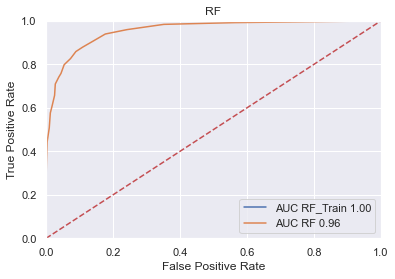

RF CLASSIFICATION ACCURACY
RF_Train  =  0.9991610738255033
RF  =  0.9085570469798657
------


RF RMSE ACCURACY
RF_Train  =  1000.9965864327676
RF  =  2801.3926761930798
------


('TRUNC_LOAN', 100)
('TRUNC_IMP_DEBTINC', 11)
('TRUNC_IMP_CLNO', 11)


In [11]:
#We've managed to up the accuracy of our predicted losses at the expense of successfully predicting a defualt. Let's see
#if the random forest does any better.

#Let's plant this random forest and see how well it predicts default
def getEnsembleTreeVars( ENSTREE, varNames ) :
    importance = ENSTREE.feature_importances_
    index = np.argsort(importance)
    theList = []
    for i in index :
        imp_val = importance[i]
        if imp_val > np.average( ENSTREE.feature_importances_ ) :
            v = int( imp_val / np.max( ENSTREE.feature_importances_ ) * 100 )
            theList.append( ( varNames[i], v ) )
    theList = sorted(theList,key=itemgetter(1),reverse=True)
    return theList

WHO = "RF"

CLM = RandomForestClassifier( n_estimators = 25, random_state=1 )
CLM = CLM.fit( X_train, Y_train[ TARGET_B ] )

TRAIN_CLM = getProbAccuracyScores( WHO + "_Train", CLM, X_train, Y_train[ TARGET_B ] )
TEST_CLM = getProbAccuracyScores( WHO, CLM, X_test, Y_test[ TARGET_B ] )

print_ROC_Curve( WHO, [ TRAIN_CLM, TEST_CLM ] ) 
print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )


feature_cols = list( X.columns.values )
vars_RF_flag = getEnsembleTreeVars( CLM, feature_cols )


# Can the random forest predict expected losses if the loan defaults?

AMT = RandomForestRegressor(n_estimators = 100, random_state=1)
AMT = AMT.fit( W_train, Z_train[TARGET_L] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, W_train, Z_train[TARGET_L] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, W_test, Z_test[TARGET_L] )
print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )

feature_cols = list( X.columns.values )
vars_RF_amt = getEnsembleTreeVars( AMT, feature_cols )

for i in vars_RF_amt :
    print( i )

RF_CLM = TEST_CLM.copy()
RF_AMT = TEST_AMT.copy()




('TRUNC_IMP_DEBTINC', 100)
('TRUNC_IMP_CLAGE', 54)
('TRUNC_LOAN', 50)
('TRUNC_IMP_VALUE', 48)
('TRUNC_IMP_DELINQ', 42)
('TRUNC_IMP_MORTDUE', 41)
('TRUNC_IMP_CLNO', 37)
('TRUNC_IMP_YOJ', 35)
('TRUNC_IMP_DEROG', 26)
('TRUNC_IMP_NINQ', 22)



('TRUNC_LOAN', 100)
('TRUNC_IMP_DEBTINC', 11)
('TRUNC_IMP_CLNO', 11)


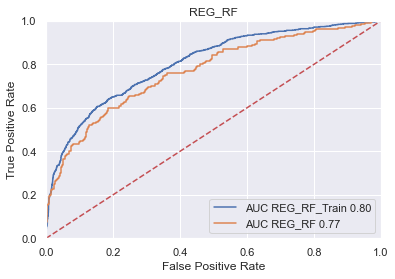

REG_RF CLASSIFICATION ACCURACY
REG_RF_Train  =  0.8418624161073825
REG_RF  =  0.822986577181208
------


REG_RF RMSE ACCURACY
REG_RF_Train  =  4381.042127794458
REG_RF  =  4973.459023628609
------



Default
---------
Total Variables:  11
INTERCEPT  =  -2.918614109380549
TRUNC_IMP_DEBTINC  =  0.07017832876657291
TRUNC_IMP_CLAGE  =  -0.006037387468196722
TRUNC_LOAN  =  -2.0852002084361244e-05
TRUNC_IMP_VALUE  =  1.4986946202818529e-06
TRUNC_IMP_DELINQ  =  0.8095690303834159
TRUNC_IMP_MORTDUE  =  -3.0031087155234427e-06
TRUNC_IMP_CLNO  =  -0.011362428077251093
TRUNC_IMP_YOJ  =  -0.008270223385014023
TRUNC_IMP_DEROG  =  0.7261211512539507
TRUNC_IMP_NINQ  =  0.1804178345223527

Loss
---------
Total Variables:  4
INTERCEPT  =  -6632.022231204115
TRUNC_LOAN  =  0.6134551239037115
TRUNC_IMP_DEBTINC  =  118.9469607594448
TRUNC_IMP_CLNO  =  236.14913321023187


In [12]:
#Hot dog! The random forest is super good at predicting a default and is also excellent at predicting loss. Could the
#regression model for the random forest possibly perform any better? Let's see if it does based on the variables the 
#random forest liked.

WHO = "REG_RF"


print("\n\n")
RF_flag = []
for i in vars_RF_flag :
    print(i)
    theVar = i[0]
    RF_flag.append( theVar )

print("\n\n")
RF_amt = []
for i in vars_RF_amt :
    print(i)
    theVar = i[0]
    RF_amt.append( theVar )


CLM = LogisticRegression( solver='newton-cg', max_iter=1000 )
CLM = CLM.fit( X_train[RF_flag], Y_train[ TARGET_B ] )

TRAIN_CLM = getProbAccuracyScores( WHO + "_Train", CLM, X_train[RF_flag], Y_train[ TARGET_B ] )
TEST_CLM = getProbAccuracyScores( WHO, CLM, X_test[RF_flag], Y_test[ TARGET_B ] )

print_ROC_Curve( WHO, [ TRAIN_CLM, TEST_CLM ] ) 
print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )


# Let's predict loan loss!

AMT = LinearRegression()
AMT = AMT.fit( W_train[RF_amt], Z_train[TARGET_L] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, W_train[RF_amt], Z_train[TARGET_L] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, W_test[RF_amt], Z_test[TARGET_L] )
print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )


REG_RF_CLM_COEF = getCoefLogit( CLM, X_train[RF_flag] )
REG_RF_AMT_COEF = getCoefLinear( AMT, X_train[RF_amt] )

REG_RF_CLM = TEST_CLM.copy()
REG_RF_AMT = TEST_AMT.copy()

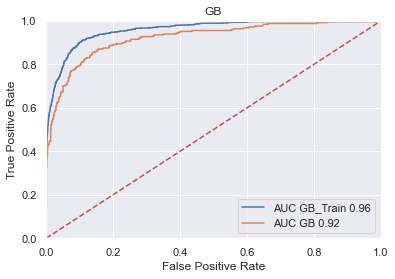

GB CLASSIFICATION ACCURACY
GB_Train  =  0.9194630872483222
GB  =  0.8951342281879194
------


GB RMSE ACCURACY
GB_Train  =  1200.933017790376
GB  =  2267.978737055079
------


('TRUNC_LOAN', 100)
('TRUNC_IMP_DEBTINC', 11)
('TRUNC_IMP_CLNO', 11)


In [13]:
#Well that's certainly a bummer. The random forest regression performs worse both at predicting a default and expected loss
#for when a loan does default. This is not the way. Perhaps gradient boosting models are, though?

#Build the gradient boosting model to predict a default

WHO = "GB"

CLM = GradientBoostingClassifier( random_state=1 )
CLM = CLM.fit( X_train, Y_train[ TARGET_B ] )

TRAIN_CLM = getProbAccuracyScores( WHO + "_Train", CLM, X_train, Y_train[ TARGET_B ] )
TEST_CLM = getProbAccuracyScores( WHO, CLM, X_test, Y_test[ TARGET_B ] )

print_ROC_Curve( WHO, [ TRAIN_CLM, TEST_CLM ] ) 
print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )


feature_cols = list( X.columns.values )
vars_GB_flag = getEnsembleTreeVars( CLM, feature_cols )


# Predict the expected losses for a defaulted loan

AMT = GradientBoostingRegressor(random_state=1)
AMT = AMT.fit( W_train, Z_train[TARGET_L] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, W_train, Z_train[TARGET_L] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, W_test, Z_test[TARGET_L] )
print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )

feature_cols = list( X.columns.values )
vars_GB_amt = getEnsembleTreeVars( AMT, feature_cols )

for i in vars_RF_amt :
    print( i )

GB_CLM = TEST_CLM.copy()
GB_AMT = TEST_AMT.copy()




('TRUNC_IMP_DEBTINC', 100)
('TRUNC_IMP_DELINQ', 28)
('TRUNC_IMP_CLAGE', 14)
('TRUNC_IMP_DEROG', 10)
('TRUNC_IMP_VALUE', 7)



('TRUNC_LOAN', 100)
('TRUNC_IMP_DEBTINC', 13)
('TRUNC_IMP_CLNO', 13)


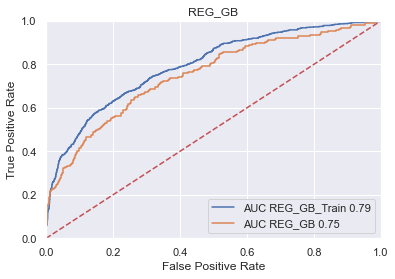

REG_GB CLASSIFICATION ACCURACY
REG_GB_Train  =  0.8382969798657718
REG_GB  =  0.8171140939597316
------


REG_GB RMSE ACCURACY
REG_GB_Train  =  4381.042127794458
REG_GB  =  4973.459023628609
------



Default
---------
Total Variables:  6
INTERCEPT  =  -3.094801002602462
TRUNC_IMP_DEBTINC  =  0.07159183358037828
TRUNC_IMP_DELINQ  =  0.7965147266128423
TRUNC_IMP_CLAGE  =  -0.006987879648829101
TRUNC_IMP_DEROG  =  0.7422477003038567
TRUNC_IMP_VALUE  =  -2.435616527587977e-06

Loss
---------
Total Variables:  4
INTERCEPT  =  -6632.022231204115
TRUNC_LOAN  =  0.6134551239037115
TRUNC_IMP_DEBTINC  =  118.9469607594448
TRUNC_IMP_CLNO  =  236.14913321023187


In [14]:
#I think these results are worth another 'hot dog!' Our accuracy in predicting a default is not quite as high, but if
#predicting losses is where the money is, and it is, then gradient boosting is the most successful with the smallest value
#for the RMSE of the test data. Could the regression model possibly perform better?

#Build the regressions gradient boosting model

WHO = "REG_GB"


print("\n\n")
GB_flag = []
for i in vars_GB_flag :
    print(i)
    theVar = i[0]
    GB_flag.append( theVar )

print("\n\n")
GB_amt = []
for i in vars_GB_amt :
    print(i)
    theVar = i[0]
    GB_amt.append( theVar )


CLM = LogisticRegression( solver='newton-cg', max_iter=1000 )
CLM = CLM.fit( X_train[GB_flag], Y_train[ TARGET_B ] )

TRAIN_CLM = getProbAccuracyScores( WHO + "_Train", CLM, X_train[GB_flag], Y_train[ TARGET_B ] )
TEST_CLM = getProbAccuracyScores( WHO, CLM, X_test[GB_flag], Y_test[ TARGET_B ] )

print_ROC_Curve( WHO, [ TRAIN_CLM, TEST_CLM ] ) 
print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )


#Predict the losses!

AMT = LinearRegression()
AMT = AMT.fit( W_train[GB_amt], Z_train[TARGET_L] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, W_train[GB_amt], Z_train[TARGET_L] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, W_test[GB_amt], Z_test[TARGET_L] )
print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )

REG_GB_CLM_COEF = getCoefLogit( CLM, X_train[GB_flag] )
REG_GB_AMT_COEF = getCoefLinear( AMT, X_train[GB_amt] )

REG_GB_CLM = TEST_CLM.copy()
REG_GB_AMT = TEST_AMT.copy()

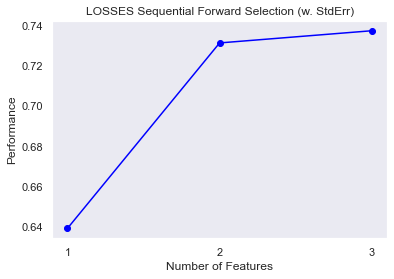

 ................... 
argmax
feature_names    (0, 1, 2)
avg_score         0.737496
Name: 3, dtype: object
 ................... 
('0', '1', '2')
TRUNC_LOAN
TRUNC_IMP_DEBTINC
TRUNC_IMP_CLNO


In [38]:
#Well we've sacrificed accuracy in both predicting defaults and expected losses, though the RMSE is very close for both
#training data and testing data. I do want to take a moment and note that the variables here make the most sense of any
#model so far. Deliquency and derogatory credit marks would be a metric I would look closely at to determine whether a
#loan is likely to default. Also, the value of the loan and a higher debt-to-income ratio as highly positively 
#correlated regarding predicting loan losses. I remain somewhat skeptical that the number of credit lines should carry the 
#amount of weight this models places in it, but an expert could help determine its level of importance.

#Let's use one more technique! Stepwise selection!

#U_train = X_train[ vars_tree_flag ] ValueError: matmul:#Input operand 0 does not have enough dimensions has 0,
#gufunc core with signature(n?,k),(k,m?)->(n?,m?) requires 1) Could not fix this error...
#stepVarNames = list( U_train.columns.values )
   #maxCols = U_train.shape[1]

#sfs = SFS( LogisticRegression( solver='newton-cg', max_iter=50),
#          k_features=( 1, maxCols ),
#          forward=True,
#          floating=False,
#          cv=5
#          )
#sfs.fit(U_train.values, Y_train[TARGET_B].values)

#   theFigure = plot_sfs(sfs.get_metric_dict(), kind=None )
#plt.title('Default Prob Sequential Forward Selection (w. StdErr)')
#plt.grid()
#plt.show()

#fm = pd.DataFrame.from_dict( sfs.get_metric_dict()).T
#dfm = dfm[ ['feature_names', 'avg_score'] ]
#dfm.avg_score = dfm.avg_score.astype(float)

#print(" ................... ")
#maxIndex = dfm.avg_score.argmax()
#print("argmax")
#print( dfm.iloc[ maxIndex, ] )
#print(" ................... ")

#stepVars = dfm.iloc[ maxIndex, ]
#stepVars = stepVars.feature_names
#print( stepVars )

#finalStepVars = []
#for i in stepVars :
#   index = int(i)
#   try :
#       theName = stepVarNames[ index ]
#       finalStepVars.append( theName )
#   except :
#       pass

#for i in finalStepVars :
#   print(i)

#U_train = X_train[ finalStepVars ]
#U_test = X_test[ finalStepVars ]

V_train = W_train[ GB_amt ]
stepVarNames = list( V_train.columns.values )
maxCols = V_train.shape[1]

sfs = SFS( LinearRegression(),
           k_features=( 1, maxCols ),
           forward=True,
           floating=False,
           scoring = 'r2',
           cv=5
           )
sfs.fit(V_train.values, Z_train[ TARGET_L ].values)

theFigure = plot_sfs(sfs.get_metric_dict(), kind=None )
plt.title('LOSSES Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

dfm = pd.DataFrame.from_dict( sfs.get_metric_dict()).T
dfm = dfm[ ['feature_names', 'avg_score'] ]
dfm.avg_score = dfm.avg_score.astype(float)

print(" ................... ")
maxIndex = dfm.avg_score.argmax()
print("argmax")
print( dfm.iloc[ maxIndex, ] )
print(" ................... ")

stepVars = dfm.iloc[ maxIndex, ]
stepVars = stepVars.feature_names
print( stepVars )

finalStepVars = []
for i in stepVars :
    index = int(i)
    try :
        theName = stepVarNames[ index ]
        finalStepVars.append( theName )
    except :
        pass

for i in finalStepVars :
    print(i)

V_train = W_train[ finalStepVars ]
V_test = W_test[ finalStepVars ]

In [37]:
#And finally we run a regression of the stepwise selection.
WHO = "REG_STEPWISE"

#Could not create based on error in last cell
#CLM = LogisticRegression( solver='newton-cg', max_iter=1000 )
#CLM = CLM.fit( U_train, Y_train[ TARGET_B ] )

#TRAIN_CLM = getProbAccuracyScores( WHO + "_Train", CLM, U_train, Y_train[ TARGET_B ] )
#TEST_CLM = getProbAccuracyScores( WHO, CLM, U_test, Y_test[ TARGET_B ] )

#print_ROC_Curve( WHO, [ TRAIN_CLM, TEST_CLM ] ) 
#print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )


# Predict the losses

AMT = LinearRegression()
AMT = AMT.fit( V_train, Z_train[TARGET_L] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, V_train, Z_train[TARGET_L] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, V_test, Z_test[TARGET_L] )
print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )

REG_STEP_CLM_COEF = getCoefLogit( CLM, U_train )
REG_STEP_AMT_COEF = getCoefLinear( AMT, V_train )

REG_STEP_CLM = TEST_CLM.copy()
REG_STEP_AMT = TEST_AMT.copy()

REG_STEPWISE RMSE ACCURACY
REG_STEPWISE_Train  =  4381.042127794458
REG_STEPWISE  =  4973.459023628609
------



Default
---------
Total Variables:  10
INTERCEPT  =  -2.9721798953993748
y_IMP_JOB_6  =  0.33138661317173923
y_IMP_JOB_5  =  -2.318448115909337e-05
y_IMP_JOB_4  =  -1.083374676641843e-06
y_IMP_JOB_3  =  0.7329461185982239
y_IMP_JOB_2  =  1.7794793994860163
y_IMP_JOB_1  =  0.6957024424763976
y_IMP_REASON_2  =  -0.006728016587096282
y_IMP_REASON_1  =  0.17270283253099517
O_LOAN  =  0.0693246469998727

Loss
---------
Total Variables:  4
INTERCEPT  =  -6632.022231204115
TRUNC_LOAN  =  0.6134551239037115
TRUNC_IMP_DEBTINC  =  118.9469607594448
TRUNC_IMP_CLNO  =  236.14913321023187


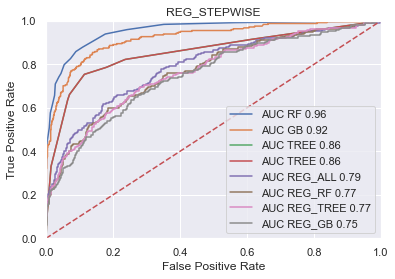

ALL CLASSIFICATION ACCURACY
RF  =  0.9085570469798657
GB  =  0.8951342281879194
TREE  =  0.8733221476510067
TREE  =  0.8733221476510067
REG_ALL  =  0.8313758389261745
REG_RF  =  0.822986577181208
REG_TREE  =  0.822986577181208
REG_GB  =  0.8171140939597316
------


ALL LOSSES MODEL ACCURACY
GB  =  2267.978737055079
RF  =  2801.3926761930798
REG_ALL  =  4147.165955888475
REG_TREE  =  4310.25669707498
TREE  =  4798.8775440606805
REG_RF  =  4973.459023628609
REG_GB  =  4973.459023628609
REG_STEPWISE  =  4973.459023628609
------




In [39]:
#Let's compare everything all together!

ALL_CLM = [ TREE_CLM, RF_CLM, GB_CLM, REG_ALL_CLM, REG_TREE_CLM, REG_RF_CLM, REG_GB_CLM, REG_STEP_CLM ]

ALL_CLM = sorted( ALL_CLM, key = lambda x: x[4], reverse=True )
print_ROC_Curve( WHO, ALL_CLM ) 

ALL_CLM = sorted( ALL_CLM, key = lambda x: x[1], reverse=True )
print_Accuracy( "ALL CLASSIFICATION ACCURACY", ALL_CLM )


ALL_AMT = [ TREE_AMT, RF_AMT, GB_AMT, REG_ALL_AMT, REG_TREE_AMT, REG_RF_AMT, REG_GB_AMT, REG_STEP_AMT ]
ALL_AMT = sorted( ALL_AMT, key = lambda x: x[1] )
print_Accuracy( "ALL LOSSES MODEL ACCURACY", ALL_AMT )


In [ ]:
#Among all models, the gradient boosting model has the best overall performance. It is just behind the random forest model,
#which can be notorious for overfitting, and blows all other models out of the water when trying to predict losses.
#In addition, the variables the gradient boosting model selected make intuitive sense and would be variables I would likely
#include if I were selecting my own variables to develop a model. Yes, regression models certainly have their strengths,
#but the gradient boosting model shows why it is often the go-to model for practical machine learning.